# Ensemble Methods with Grid Search CV

This notebook demonstrates ensemble methods (Voting, Bagging, Stacking) with comprehensive hyperparameter tuning using Grid Search and Cross Validation.


In [1]:
# Standard library imports
import warnings
from typing import Dict, List, Tuple, Any

# Third-party imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    StackingClassifier,
    VotingClassifier,
)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# Configuration
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)
pd.set_option("float_format", "{:.4f}".format)

In [2]:
# Constants
RANDOM_STATE = 42
CV_FOLDS = 5
TEST_SIZE = 0.2

## Data Loading and Preprocessing


In [3]:
# Load breast cancer dataset
raw_data = load_breast_cancer()

print(f"Dataset shape: {raw_data['data'].shape}")
print(f"Target distribution: {np.bincount(raw_data['target'])}")

Dataset shape: (569, 30)
Target distribution: [212 357]


In [5]:
# Create DataFrame
data = raw_data["data"]
feature_names = raw_data["feature_names"]

raw_df = pd.DataFrame(data, columns=feature_names)
raw_df["target"] = raw_data["target"]

print("Raw data shape:", raw_df.shape)
raw_df.head()

Raw data shape: (569, 31)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.9900,10.3800,122.8000,1001.0000,0.1184,0.2776,0.3001,0.1471,0.2419,0.0787,1.0950,0.9053,8.5890,153.4000,0.0064,0.0490,0.0537,0.0159,0.0300,0.0062,25.3800,17.3300,184.6000,2019.0000,0.1622,0.6656,0.7119,0.2654,0.4601,0.1189,0
1,20.5700,17.7700,132.9000,1326.0000,0.0847,0.0786,0.0869,0.0702,0.1812,0.0567,0.5435,0.7339,3.3980,74.0800,0.0052,0.0131,0.0186,0.0134,0.0139,0.0035,24.9900,23.4100,158.8000,1956.0000,0.1238,0.1866,0.2416,0.1860,0.2750,0.0890,0
2,19.6900,21.2500,130.0000,1203.0000,0.1096,0.1599,0.1974,0.1279,0.2069,0.0600,0.7456,0.7869,4.5850,94.0300,0.0062,0.0401,0.0383,0.0206,0.0225,0.0046,23.5700,25.5300,152.5000,1709.0000,0.1444,0.4245,0.4504,0.2430,0.3613,0.0876,0
3,11.4200,20.3800,77.5800,386.1000,0.1425,0.2839,0.2414,0.1052,0.2597,0.0974,0.4956,1.1560,3.4450,27.2300,0.0091,0.0746,0.0566,0.0187,0.0596,0.0092,14.9100,26.5000,98.8700,567.7000,0.2098,0.8663,0.6869,0.2575,0.6638,0.1730,0
4,20.2900,14.3400,135.1000,1297.0000,0.1003,0.1328,0.1980,0.1043,0.1809,0.0588,0.7572,0.7813,5.4380,94.4400,0.0115,0.0246,0.0569,0.0188,0.0176,0.0051,22.5400,16.6700,152.2000,1575.0000,0.1374,0.2050,0.4000,0.1625,0.2364,0.0768,0


In [6]:
# Standardize features
scaler = StandardScaler()

X_scaled = scaler.fit_transform(raw_df.drop(["target"], axis=1))
df = pd.DataFrame(X_scaled, columns=feature_names)
df["target"] = raw_df["target"]

print("Scaled data shape:", df.shape)
df.head()

Scaled data shape: (569, 31)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,1.0971,-2.0733,1.2699,0.9844,1.5685,3.2835,2.6529,2.5325,2.2175,2.2557,2.4897,-0.5653,2.8330,2.4876,-0.2140,1.3169,0.7240,0.6608,1.1488,0.9071,1.8867,-1.3593,2.3036,2.0012,1.3077,2.6167,2.1095,2.2961,2.7506,1.9370,0
1,1.8298,-0.3536,1.6860,1.9087,-0.8270,-0.4871,-0.0238,0.5481,0.0014,-0.8687,0.4993,-0.8762,0.2633,0.7424,-0.6054,-0.6929,-0.4408,0.2602,-0.8055,-0.0994,1.8059,-0.3692,1.5351,1.8905,-0.3756,-0.4304,-0.1467,1.0871,-0.2439,0.2812,0
2,1.5799,0.4562,1.5665,1.5589,0.9422,1.0529,1.3635,2.0372,0.9397,-0.3980,1.2287,-0.7801,0.8509,1.1813,-0.2970,0.8150,0.2131,1.4248,0.2370,0.2936,1.5119,-0.0240,1.3475,1.4563,0.5274,1.0829,0.8550,1.9550,1.1523,0.2014,0
3,-0.7689,0.2537,-0.5927,-0.7645,3.2836,3.4029,1.9159,1.4517,2.8674,4.9109,0.3264,-0.1104,0.2866,-0.2884,0.6897,2.7443,0.8195,1.1150,4.7327,2.0475,-0.2815,0.1340,-0.2499,-0.5500,3.3943,3.8934,1.9896,2.1758,6.0460,4.9350,0
4,1.7503,-1.1518,1.7766,1.8262,0.2804,0.5393,1.3710,1.4285,-0.0096,-0.5624,1.2705,-0.7902,1.2732,1.1904,1.4831,-0.0485,0.8285,1.1442,-0.3611,0.4993,1.2986,-1.4668,1.3385,1.2207,0.2206,-0.3134,0.6132,0.7293,-0.8684,-0.3971,0


In [7]:
df['target'].value_counts()

target
1    357
0    212
Name: count, dtype: int64

In [8]:
# Train-test split
X = df.drop(["target"], axis=1)
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Target distribution in train: {np.bincount(y_train)}")
print(f"Target distribution in test: {np.bincount(y_test)}")

Training set: (455, 30)
Test set: (114, 30)
Target distribution in train: [170 285]
Target distribution in test: [42 72]


- stratify 미적용 시 : 
    - train set : 455 (악성: 180, 양성: 275)
    - test set : 114 (악성: 32, 양성: 82)
    - ratio -> train(39.6% : 60.4%), test(28.1%, 71.9%)
- stratify = y : 
    - train set : 455 (악성: 170, 양성: 285)
    - test set : 114 (악성: 42, 양성: 72)
    - ratio -> train(37.4% : 62.6%), test(36.8% : 63.2%)
- 적용 시 train/test set에 대한 라벨별 분포를 일정하게 맞출 수 있음 

## Helper Functions


In [9]:
def evaluate_model(
    model, X_train, y_train, X_test, y_test, model_name: str
) -> Dict[str, float]:
    """Evaluate model performance and return metrics."""
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)

    y_pred = model.predict(X_test)

    return {
        "model_name": model_name,
        "train_score": train_score,
        "test_score": test_score,
        "score_diff": abs(train_score - test_score),
        "predictions": y_pred,
    }


def plot_confusion_matrices(results: List[Dict], y_test) -> None:
    """Plot confusion matrices for multiple models."""
    n_models = len(results)
    fig, axes = plt.subplots(1, n_models, figsize=(4 * n_models, 4))

    if n_models == 1:
        axes = [axes]

    for i, result in enumerate(results):
        cm = confusion_matrix(y_test, result["predictions"])
        ConfusionMatrixDisplay(cm).plot(ax=axes[i])
        axes[i].set_title(
            f"{result['model_name']}\nTest Score: {result['test_score']:.4f}"
        )

    plt.tight_layout()
    plt.show()


def create_results_dataframe(results: List[Dict]) -> pd.DataFrame:
    """Create a results DataFrame from evaluation results."""
    df_results = pd.DataFrame(results)

    # Sort by score difference (ascending), then by test score (descending)
    df_results = df_results.sort_values(
        by=["score_diff", "test_score"], ascending=[True, False]
    ).reset_index(drop=True)

    return df_results

## 1. Voting Classifier with Grid Search


In [10]:
# Define base estimators for voting
base_estimators = [
    ("lr", LogisticRegression(random_state=RANDOM_STATE)),
    ("dt", DecisionTreeClassifier(random_state=RANDOM_STATE)),
    ("knn", KNeighborsClassifier()),
]

# Define parameter grid for voting classifier
voting_params = {
    "voting": ["hard", "soft"],
    "lr__C": [0.1, 1.0, 10.0],
    "dt__max_depth": [3, 5, 10, None],
    "dt__min_samples_split": [2, 5, 10],
    "knn__n_neighbors": [3, 5, 7, 9],
    "knn__weights": ["uniform", "distance"],
}

print("Voting Classifier Parameter Grid:")
for param, values in voting_params.items():
    print(f"  {param}: {values}")

Voting Classifier Parameter Grid:
  voting: ['hard', 'soft']
  lr__C: [0.1, 1.0, 10.0]
  dt__max_depth: [3, 5, 10, None]
  dt__min_samples_split: [2, 5, 10]
  knn__n_neighbors: [3, 5, 7, 9]
  knn__weights: ['uniform', 'distance']


In [11]:
# Create and fit voting classifier with grid search
voting_clf = VotingClassifier(estimators=base_estimators)

voting_grid = GridSearchCV(
    estimator=voting_clf,
    param_grid=voting_params,
    cv=CV_FOLDS,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1,
)

print("Starting Grid Search for Voting Classifier...")
voting_grid.fit(X_train, y_train)

print(f"\nBest parameters: {voting_grid.best_params_}")
print(f"Best cross-validation score: {voting_grid.best_score_:.4f}")

Starting Grid Search for Voting Classifier...
Fitting 5 folds for each of 576 candidates, totalling 2880 fits

Best parameters: {'dt__max_depth': 5, 'dt__min_samples_split': 2, 'knn__n_neighbors': 3, 'knn__weights': 'uniform', 'lr__C': 0.1, 'voting': 'hard'}
Best cross-validation score: 0.9780


In [12]:
# Evaluate voting classifier
voting_results = evaluate_model(
    voting_grid.best_estimator_,
    X_train,
    y_train,
    X_test,
    y_test,
    "Voting (Grid Search)",
)

print("Voting Classifier Results:")
print(f"  Train Score: {voting_results['train_score']:.4f}")
print(f"  Test Score: {voting_results['test_score']:.4f}")
print(f"  Score Difference: {voting_results['score_diff']:.4f}")

Voting Classifier Results:
  Train Score: 0.9912
  Test Score: 0.9825
  Score Difference: 0.0088


## 2. Bagging (Random Forest) with Grid Search


In [13]:
# Define parameter grid for Random Forest
rf_params = {
    "n_estimators": [50, 100, 200],
    "max_depth": [3, 5, 10, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", None],
    "bootstrap": [True, False],
}

print("Random Forest Parameter Grid:")
for param, values in rf_params.items():
    print(f"  {param}: {values}")

Random Forest Parameter Grid:
  n_estimators: [50, 100, 200]
  max_depth: [3, 5, 10, None]
  min_samples_split: [2, 5, 10]
  min_samples_leaf: [1, 2, 4]
  max_features: ['sqrt', 'log2', None]
  bootstrap: [True, False]


In [14]:
# Create and fit Random Forest with grid search
rf_clf = RandomForestClassifier(random_state=RANDOM_STATE)

rf_grid = GridSearchCV(
    estimator=rf_clf,
    param_grid=rf_params,
    cv=CV_FOLDS,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1,
)

print("Starting Grid Search for Random Forest...")
rf_grid.fit(X_train, y_train)

print(f"\nBest parameters: {rf_grid.best_params_}")
print(f"Best cross-validation score: {rf_grid.best_score_:.4f}")

Starting Grid Search for Random Forest...
Fitting 5 folds for each of 648 candidates, totalling 3240 fits

Best parameters: {'bootstrap': False, 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation score: 0.9692


In [15]:
# Evaluate Random Forest
rf_results = evaluate_model(
    rf_grid.best_estimator_,
    X_train,
    y_train,
    X_test,
    y_test,
    "Random Forest (Grid Search)",
)

print("Random Forest Results:")
print(f"  Train Score: {rf_results['train_score']:.4f}")
print(f"  Test Score: {rf_results['test_score']:.4f}")
print(f"  Score Difference: {rf_results['score_diff']:.4f}")

# Feature importance
feature_importance = pd.DataFrame(
    {
        "feature": feature_names,
        "importance": rf_grid.best_estimator_.feature_importances_,
    }
).sort_values("importance", ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

Random Forest Results:
  Train Score: 1.0000
  Test Score: 0.9561
  Score Difference: 0.0439

Top 10 Most Important Features:
                 feature  importance
23            worst area      0.1286
27  worst concave points      0.1204
20          worst radius      0.1102
2         mean perimeter      0.0992
3              mean area      0.0704
6         mean concavity      0.0595
22       worst perimeter      0.0586
7    mean concave points      0.0579
0            mean radius      0.0471
13            area error      0.0276


## 3. Stacking Classifier with Grid Search


In [16]:
# Define base estimators for stacking
stacking_base = [
    ("lr", LogisticRegression(random_state=RANDOM_STATE)),
    ("dt", DecisionTreeClassifier(random_state=RANDOM_STATE)),
    ("rf", RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=50)),
]

# Define meta-estimator
meta_estimator = LogisticRegression(random_state=RANDOM_STATE)

# Define parameter grid for stacking classifier
stacking_params = {
    "lr__C": [0.1, 1.0, 10.0],
    "dt__max_depth": [3, 5, 10],
    "dt__min_samples_split": [2, 5],
    "rf__max_depth": [3, 5, 10],
    "rf__min_samples_split": [2, 5],
    "final_estimator__C": [0.1, 1.0, 10.0],
}

print("Stacking Classifier Parameter Grid:")
for param, values in stacking_params.items():
    print(f"  {param}: {values}")

Stacking Classifier Parameter Grid:
  lr__C: [0.1, 1.0, 10.0]
  dt__max_depth: [3, 5, 10]
  dt__min_samples_split: [2, 5]
  rf__max_depth: [3, 5, 10]
  rf__min_samples_split: [2, 5]
  final_estimator__C: [0.1, 1.0, 10.0]


In [17]:
# Create and fit stacking classifier with grid search
stacking_clf = StackingClassifier(
    estimators=stacking_base, final_estimator=meta_estimator, cv=CV_FOLDS
)

stacking_grid = GridSearchCV(
    estimator=stacking_clf,
    param_grid=stacking_params,
    cv=CV_FOLDS,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1,
)

print("Starting Grid Search for Stacking Classifier...")
stacking_grid.fit(X_train, y_train)

print(f"\nBest parameters: {stacking_grid.best_params_}")
print(f"Best cross-validation score: {stacking_grid.best_score_:.4f}")

Starting Grid Search for Stacking Classifier...
Fitting 5 folds for each of 324 candidates, totalling 1620 fits

Best parameters: {'dt__max_depth': 5, 'dt__min_samples_split': 5, 'final_estimator__C': 10.0, 'lr__C': 1.0, 'rf__max_depth': 10, 'rf__min_samples_split': 2}
Best cross-validation score: 0.9824


In [18]:
# Evaluate Stacking Classifier
stacking_results = evaluate_model(
    stacking_grid.best_estimator_,
    X_train,
    y_train,
    X_test,
    y_test,
    "Stacking (Grid Search)",
)

print("Stacking Classifier Results:")
print(f"  Train Score: {stacking_results['train_score']:.4f}")
print(f"  Test Score: {stacking_results['test_score']:.4f}")
print(f"  Score Difference: {stacking_results['score_diff']:.4f}")

Stacking Classifier Results:
  Train Score: 0.9912
  Test Score: 0.9649
  Score Difference: 0.0263


## 4. Additional Boosting Methods with Grid Search


In [21]:
# AdaBoost with Grid Search
ada_params = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.01, 0.1, 0.5, 1.0],
}

ada_grid = GridSearchCV(
    AdaBoostClassifier(random_state=RANDOM_STATE),
    param_grid=ada_params,
    cv=CV_FOLDS,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)

print("Starting Grid Search for AdaBoost...")
ada_grid.fit(X_train, y_train)

print(f"\nBest parameters: {ada_grid.best_params_}")
print(f"Best cross-validation score: {ada_grid.best_score_:.4f}")

Starting Grid Search for AdaBoost...
Fitting 5 folds for each of 12 candidates, totalling 60 fits


/Users/a05131/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/a05131/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/a05131/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/a05131/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be r


Best parameters: {'learning_rate': 0.1, 'n_estimators': 200}
Best cross-validation score: 0.9736


In [ ]:
# XGBoost with Grid Search
xgb_params = {
    "n_estimators": [50, 100, 200],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.2],
    "subsample": [0.8, 0.9, 1.0],
}

# eval_metric 옵션 추가
# "logloss" : 이진 분류에서 사용
xgb_grid = GridSearchCV(
    XGBClassifier(random_state=RANDOM_STATE, eval_metric="logloss"),
    param_grid=xgb_params,
    cv=CV_FOLDS,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1,
)

print("Starting Grid Search for XGBoost...")
xgb_grid.fit(X_train, y_train)

print(f"\nBest parameters: {xgb_grid.best_params_}")
print(f"Best cross-validation score: {xgb_grid.best_score_:.4f}")

Starting Grid Search for XGBoost...
Fitting 5 folds for each of 81 candidates, totalling 405 fits

Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.9}
Best cross-validation score: 0.9802


In [24]:
# LightGBM with Grid Search
lgb_params = {
    "n_estimators": [50, 100, 200],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.2],
    "num_leaves": [31, 50, 100],
}

lgb_grid = GridSearchCV(
    LGBMClassifier(random_state=RANDOM_STATE, verbose=-1),
    param_grid=lgb_params,
    cv=CV_FOLDS,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1,
)

print("Starting Grid Search for LightGBM...")
lgb_grid.fit(X_train, y_train)

print(f"\nBest parameters: {lgb_grid.best_params_}")
print(f"Best cross-validation score: {lgb_grid.best_score_:.4f}")

Starting Grid Search for LightGBM...
Fitting 5 folds for each of 81 candidates, totalling 405 fits

Best parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'num_leaves': 31}
Best cross-validation score: 0.9802


## 5. Results Comparison


In [25]:
# Evaluate all models
ada_results = evaluate_model(
    ada_grid.best_estimator_, X_train, y_train, X_test, y_test, "AdaBoost (Grid Search)"
)

xgb_results = evaluate_model(
    xgb_grid.best_estimator_, X_train, y_train, X_test, y_test, "XGBoost (Grid Search)"
)

lgb_results = evaluate_model(
    lgb_grid.best_estimator_, X_train, y_train, X_test, y_test, "LightGBM (Grid Search)"
)

# Collect all results
all_results = [
    voting_results,
    rf_results,
    stacking_results,
    ada_results,
    xgb_results,
    lgb_results,
]

# Create results DataFrame
results_df = create_results_dataframe(all_results)

print("\n=== FINAL RESULTS COMPARISON ===")
print(
    results_df[["model_name", "train_score", "test_score", "score_diff"]].to_string(
        index=False
    )
)


=== FINAL RESULTS COMPARISON ===
                 model_name  train_score  test_score  score_diff
       Voting (Grid Search)       0.9912      0.9825      0.0088
     Stacking (Grid Search)       0.9912      0.9649      0.0263
     LightGBM (Grid Search)       1.0000      0.9649      0.0351
Random Forest (Grid Search)       1.0000      0.9561      0.0439
     AdaBoost (Grid Search)       1.0000      0.9561      0.0439
      XGBoost (Grid Search)       1.0000      0.9561      0.0439


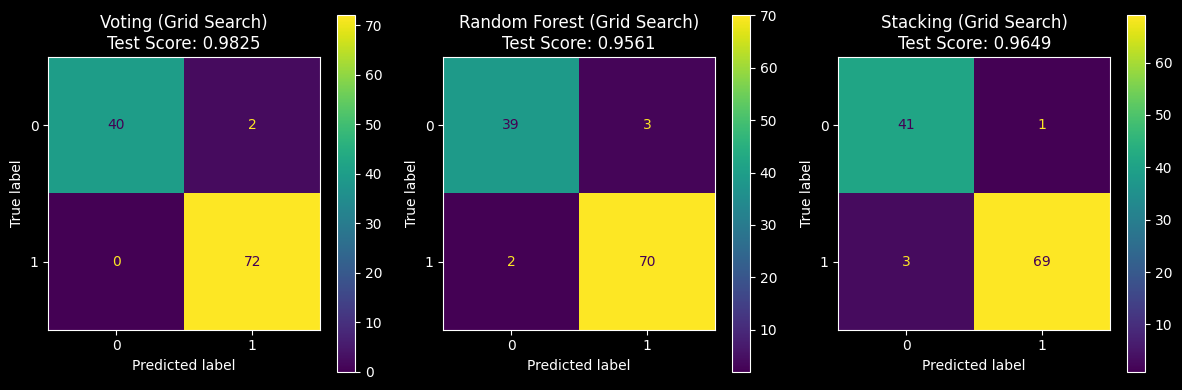

In [26]:
# Plot confusion matrices for top 3 models
top_3_results = all_results[:3]
plot_confusion_matrices(top_3_results, y_test)

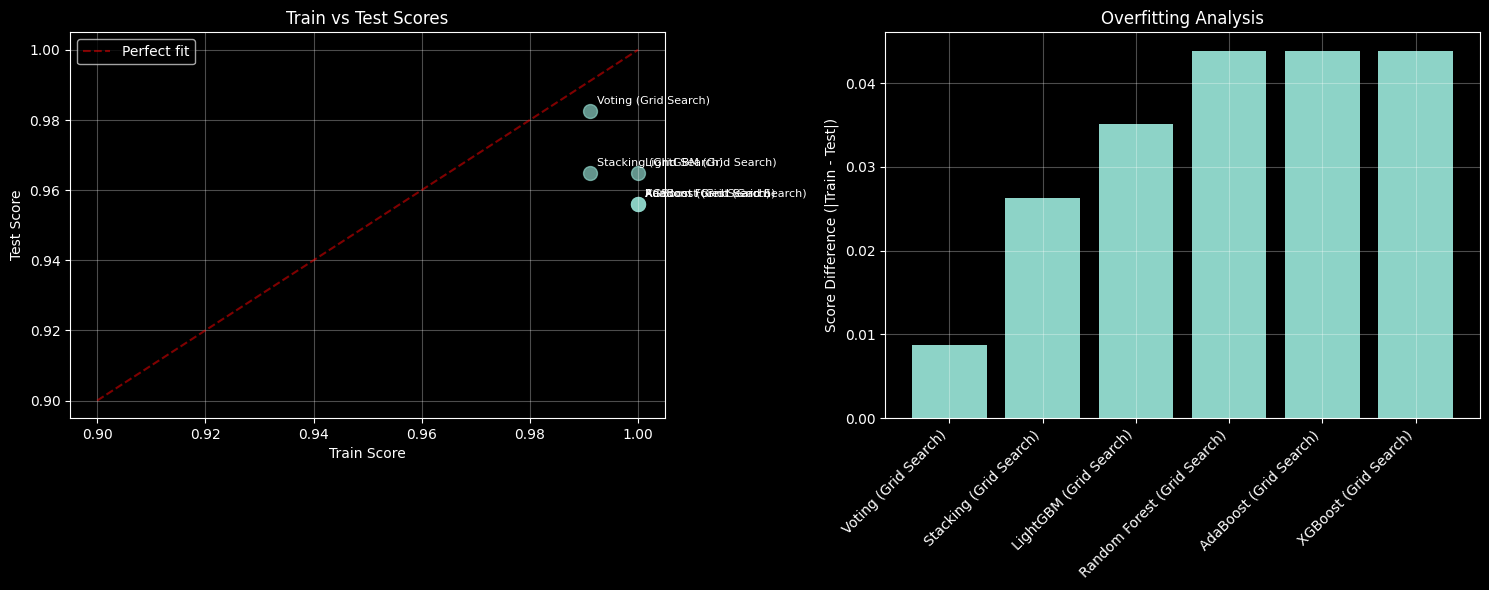

In [27]:
# Performance comparison plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Train vs Test scores
ax1.scatter(results_df["train_score"], results_df["test_score"], s=100, alpha=0.7)
for i, row in results_df.iterrows():
    ax1.annotate(
        row["model_name"],
        (row["train_score"], row["test_score"]),
        xytext=(5, 5),
        textcoords="offset points",
        fontsize=8,
    )
ax1.plot([0.9, 1.0], [0.9, 1.0], "r--", alpha=0.5, label="Perfect fit")
ax1.set_xlabel("Train Score")
ax1.set_ylabel("Test Score")
ax1.set_title("Train vs Test Scores")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Score difference
ax2.bar(range(len(results_df)), results_df["score_diff"])
ax2.set_xticks(range(len(results_df)))
ax2.set_xticklabels(results_df["model_name"], rotation=45, ha="right")
ax2.set_ylabel("Score Difference (|Train - Test|)")
ax2.set_title("Overfitting Analysis")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [28]:
# Detailed classification report for best model
best_model = all_results[0]  # First model after sorting
print(f"\n=== DETAILED CLASSIFICATION REPORT FOR {best_model['model_name']} ===")
print(classification_report(y_test, best_model["predictions"]))


=== DETAILED CLASSIFICATION REPORT FOR Voting (Grid Search) ===
              precision    recall  f1-score   support

           0       1.00      0.95      0.98        42
           1       0.97      1.00      0.99        72

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



## 6. Summary and Conclusions


In [29]:
print("\n=== SUMMARY ===")
print(f"Dataset: Breast Cancer (569 samples, 30 features)")
print(f"Train-Test Split: {int((1-TEST_SIZE)*100)}%-{int(TEST_SIZE*100)}%")
print(f"Cross-Validation: {CV_FOLDS}-fold")
print(f"\nBest Performing Model: {results_df.iloc[0]['model_name']}")
print(f"  Test Score: {results_df.iloc[0]['test_score']:.4f}")
print(f"  Score Difference: {results_df.iloc[0]['score_diff']:.4f}")

print("\n=== KEY INSIGHTS ===")
print("1. Grid Search with Cross-Validation helps find optimal hyperparameters")
print("2. Ensemble methods generally show good performance on this dataset")
print("3. Score difference indicates overfitting - lower is better")
print("4. All models achieve high accuracy (>95%) on breast cancer classification")


=== SUMMARY ===
Dataset: Breast Cancer (569 samples, 30 features)
Train-Test Split: 80%-20%
Cross-Validation: 5-fold

Best Performing Model: Voting (Grid Search)
  Test Score: 0.9825
  Score Difference: 0.0088

=== KEY INSIGHTS ===
1. Grid Search with Cross-Validation helps find optimal hyperparameters
2. Ensemble methods generally show good performance on this dataset
3. Score difference indicates overfitting - lower is better
4. All models achieve high accuracy (>95%) on breast cancer classification


# End of Documents